# Import

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
tfds = tf.data.Dataset
print('TF Version = %s'%(tf.__version__))

TensorFlow 2.x selected.
TF Version = 2.1.0


In [0]:
import tensorflow
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import numpy as np
import sys
import time
import contextlib
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline
print('TF Keras Version = %s'%(tfk.__version__))

TF Keras Version = 2.2.4-tf


# Preprocessing

## Load

In [0]:
IMAGE_SIZE = 28

In [0]:
mnist = tfk.datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = (x_train.reshape(-1, IMAGE_SIZE**2) / 255.).astype(np.float32)
x_test = (x_test.reshape(-1, IMAGE_SIZE**2) / 255.).astype(np.float32)
t_train = np.eye(10)[t_train].astype(np.float32)
t_test = np.eye(10)[t_test].astype(np.float32)

x_train[x_train >= .5] = 1.
x_train[x_train < .5] = 0.
x_test[x_test >= .5] = 1.
x_test[x_test < .5] = 0.

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def plot_images(imgs, labs, n=4):
  for i,item in enumerate(zip(imgs,labs)):
    if i >= n**2: return
    img,lab = item[0],item[1]
    plt.subplot(n, n, i+1)
    plt.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(str(np.argmax(lab)), color="k")
    plt.subplots_adjust(hspace=0.4)
  plt.show()

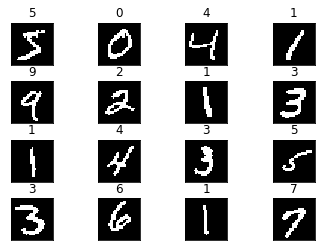

In [0]:
plot_images(x_train, t_train)

## Pipeline

In [0]:
TRAIN_BATCH_SIZE = 100
TRAIN_SAMPLE_SIZE = TRAIN_BATCH_SIZE*100
TEST_BATCH_SIZE = 1000

mnist_train = tfds.from_tensor_slices((x_train, t_train)).cache()
mnist_train = mnist_train.prefetch(tf.data.experimental.AUTOTUNE)
mnist_train = mnist_train.shuffle(TRAIN_SAMPLE_SIZE, seed=0, reshuffle_each_iteration=True)
mnist_train = mnist_train.batch(TRAIN_BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.from_tensor_slices((x_test, t_test)).cache()
mnist_test = mnist_test.batch(TEST_BATCH_SIZE, drop_remainder=True)

# Model

## Encoder

In [0]:
class Encoder(tfk.Model):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    self.l1 = tfkl.Dense(512, activation='relu')
    self.l2 = tfkl.Dense(256, activation='relu')
    self.mu = tfkl.Dense(latent_dim, activation=None)
    self.logvar = tfkl.Dense(latent_dim, activation=None)
  
  def call(self, x):
    x = self.l1(x)
    x = self.l2(x)
    mu = self.mu(x)
    logvar = self.logvar(x)
    return mu, logvar

## Decoder


In [0]:
class Decoder(tfk.Model):
  def __init__(self, output_dim):
    super(Decoder, self).__init__()
    self.l1 = tfkl.Dense(256, activation='relu')
    self.l2 = tfkl.Dense(512, activation='relu')
    self.l3 = tfkl.Dense(output_dim, activation=None)
    self.ls = [self.l1, self.l2, self.l3]

  def call(self, x):
    for layer in self.ls: x = layer(x)
    return x

## Planar flow

In [0]:
class PlanarFlow(tfkl.Layer):

  def __init__(self, input_dim, depth):
    super(PlanarFlow, self).__init__()

    self.input_dim = input_dim
    self.depth = depth
    self.h = lambda z: tf.tanh(z)
    self.h_prime = lambda z: 1. - tf.tanh(z)**2
    self.m = lambda z: -1. + tf.math.log(1. + tf.exp(z))

    if self.depth > 0:
      self.lst_u = [tf.Variable(.01*tf.random.truncated_normal((1,self.input_dim)), trainable=True) for i in range(self.depth)]
      self.lst_w = [tf.Variable(.01*tf.random.truncated_normal((1,self.input_dim)), trainable=True) for i in range(self.depth)]
      self.lst_b = [tf.Variable(tf.zeros(1), trainable=True) for i in range(self.depth)]
  

  @tf.function
  def call(self, z, logq, eps=1e-8, k_stop=None):

    for i in range(self.depth):
      u, w, b = self.lst_u[i], self.lst_w[i], self.lst_b[i]
      
      # To satisfy the sufficient condition of invertibility,
      # u_hat is used instead of u 
      w_hat = w / tf.reduce_sum(w*w)
      u_dot_w = tf.reduce_sum(u*w)
      u_hat = u + (self.m(u_dot_w) - u_dot_w) * w_hat
      
      arg = tf.expand_dims(tf.reduce_sum(z*w, -1), -1) + b
      psi = self.h_prime(arg) * w
      det_jac = tf.abs(1. + tf.reduce_sum(psi*u_hat, -1))
      logq = logq - tf.math.log(det_jac+eps)
      z = z + u_hat * self.h(arg)
      
      if i+1 == k_stop: return z, logq
    
    return z, logq

## VAE

In [0]:
LOG2PI = tf.math.log(2.*np.pi)


class VAE(tfk.Model):
  def __init__(self, input_dim, latent_dim, depth=0):
    super(VAE, self).__init__()
    self._encoder = Encoder(latent_dim)
    self._decoder = Decoder(input_dim) # input_dim == output_dim
    self._flow = PlanarFlow(latent_dim, depth)
  
  def encode(self, x):
    return self._encoder(x)
  
  @tf.function
  def reparameterize(self, mu, logvar):
    eps = tf.random.normal(shape=mu.shape)
    return eps * tf.exp(logvar * .5) + mu
  
  def encode_and_reparametrize(self, x):
    mu, logvar = self.encode(x)
    return self.reparameterize(mu, logvar)
  
  @tf.function
  def log_normal_pdf(self, samples, mu, logvar):
    return tf.reduce_sum( -.5 * ((samples-mu)**2. * tf.exp(-logvar) + logvar + LOG2PI), axis=-1)
  
  def encode_and_flow(self, x):
    mu, logvar = self.encode(x)
    z0 = self.reparameterize(mu, logvar)
    logq0 = self.log_normal_pdf(z0, mu, logvar)
    zk, logqk = self._flow(z0, logq0)
    return zk, logqk
  
  def decode(self, z, to_prob=False):
    if to_prob:
      return tf.nn.sigmoid(self._decoder(z))
    else:
      return self._decoder(z)

# Training

## Utils

In [0]:
@contextlib.contextmanager
def measure_time():
  start = time.time()
  try:
    yield
  finally:
    elapsed = time.time() - start
    print("\nElapsed Time %f [sec]"%(elapsed))

@contextlib.contextmanager
def overwriting_stdout():
  org_write = sys.stdout.write
  def overwrite(text):
    org_write("\r%s" % text)
    sys.stdout.flush()
  sys.stdout.write = overwrite
  try:
    yield
  finally:
    sys.stdout.write = org_write

## Trainer

In [0]:
class Trainer():

  def __init__(self):
    pass
    # All instance methods look static,
    # but an instance of Trainer has their graphs internally.
    # See the @tf.function method in detals.

  
  def calc_loss(self, vae, x, beta=1.):
    zk, logqk = vae.encode_and_flow(x)
    x_logit = vae.decode(zk, to_prob=False)
    
    # reconstruction error
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=-1)

    # KL divergence
    logpz = vae.log_normal_pdf(zk, 0., 0.) # prior
    kl_div = logqk - logpz

    # negative ELBO
    return tf.reduce_mean(-beta*logpx_z + kl_div)


  @tf.function
  def train_step(self, vae, x, optimizer, beta=1.):
    with tf.GradientTape() as tape:
      loss = self.calc_loss(vae, x, beta)
    variables = tape.watched_variables()
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return loss
  

  def train(self, vae, optimizer, n_epochs):
    losses = []
    for epoch, test_batch in zip(range(n_epochs), mnist_test.repeat()):
      beta = 1. # np.min([1., 0.01+epoch/1e4])
      for x, _ in mnist_train:
        _ = self.train_step(vae, x, optimizer, beta)
      loss = self.calc_loss(vae, test_batch[0])
      losses.append(loss)
      if epoch % 2 == 0:
        sys.stdout.write('epoch %i: test loss = %f' % (epoch+1, loss))
    return losses

## Optimization

In [0]:
NUM_EPOCHS = 50
LR = 1e-3

lst_latent_dims = [2, 20]
lst_depths = [0, 10, 20]
dic_vae = OrderedDict()
dic_loss = OrderedDict()

for latent_dim in lst_latent_dims:
  for depth in lst_depths:
    name = 'vae_latent{0:0=2}_depth{1:0=2}'.format(latent_dim, depth)
    vae = VAE(IMAGE_SIZE**2, latent_dim=latent_dim, depth=depth)
    optimizer = tfk.optimizers.Adam(LR)
    trainer = Trainer()

    print('\n', name)
    with measure_time(), overwriting_stdout():
      l = trainer.train(vae, optimizer, NUM_EPOCHS+1)
    dic_vae[name] = vae
    dic_loss[name] = l


 vae_latent02_depth00
epoch 51: test loss = 135.410278
Elapsed Time 595.278770 [sec]

 vae_latent02_depth10
epoch 51: test loss = 134.723816
Elapsed Time 649.515402 [sec]

 vae_latent02_depth20
epoch 51: test loss = 139.667831
Elapsed Time 732.811341 [sec]

 vae_latent20_depth00
epoch 51: test loss = 80.603539
Elapsed Time 626.558720 [sec]

 vae_latent20_depth10
epoch 51: test loss = 79.410576
Elapsed Time 688.536620 [sec]

 vae_latent20_depth20
epoch 51: test loss = 79.519394
Elapsed Time 750.783654 [sec]


# Results

## Comparisons

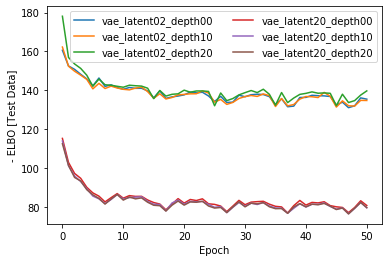

In [0]:
for name, curve in dic_loss.items():
  plt.plot(curve, label=name)
plt.xlabel('Epoch')
plt.ylabel('- ELBO [Test Data]')
plt.legend(ncol=2, loc='upper right')
plt.show()

In [0]:
def calc_loss(vae, x):
  zk, logqk = vae.encode_and_flow(x)
  x_logit = vae.decode(zk, to_prob=False)
  
  # reconstruction error
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=-1)

  # KL divergence
  logpz = vae.log_normal_pdf(zk, 0., 0.) # prior
  kl_div = logqk - logpz

  # negative ELBO
  return tf.reduce_mean(-logpx_z + kl_div).numpy()


for name, vae in dic_vae.items():
  loss = calc_loss(vae, tf.cast(x_test, tf.float32))
  print('{0}: -ELBO = {1:.5f}'.format(name, loss))

vae_latent02_depth00: -ELBO = 134.97447
vae_latent02_depth10: -ELBO = 134.52927
vae_latent02_depth20: -ELBO = 136.86426
vae_latent20_depth00: -ELBO = 80.69339
vae_latent20_depth10: -ELBO = 79.68916
vae_latent20_depth20: -ELBO = 79.60484


## Case of 2-D Latent Space

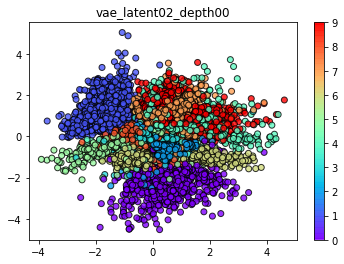

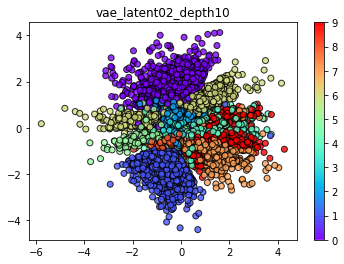

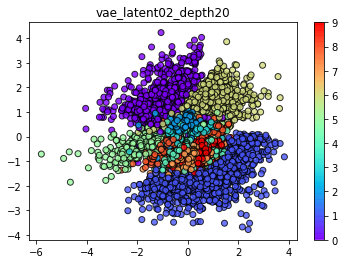

In [0]:
for name, vae in dic_vae.items():
  if 'latent02' not in name: continue
  zk, _ = vae.encode_and_flow(tf.cast(x_test, tf.float32))
  labels = t_test.argmax(axis=-1)
  plt.title(name)
  plt.scatter(zk[:,0], zk[:,1], c=labels, edgecolors='k', alpha=0.8, cmap='rainbow')
  plt.colorbar()
  plt.show()

# References

1. https://arxiv.org/abs/1312.6114
1. https://www.tensorflow.org/tutorials/generative/cvae
1. https://github.com/abdulfatir/normalizing-flows